In [1]:
import pandas as pd
from datetime import datetime as dt
from glob import glob 
from matplotlib import pyplot as plt
import numpy as np

### Track Data

In [2]:
files=glob('Track_Data/*.txt') #combine all track data .txt files together
exceptions = [] 
cols = ['Basin', 'CY', 'WarningDate', 'TechNum', 'Tech', 'Tau', 'Lat', 'Lon', 'MaxWind', 'MinSeaPres','TY',
        'RAD','Windcode','RAD1','RAD2','RAD3','RAD4','RADP','RRP','MRD','Gusts','Eye','Subregion','MaxSeas',
       'Initials','DIR','Speed','StormName','Depth','SEAS','Seascode','SEAS1','SEAS2','SEAS3','SEAS4'] 
#set column names for each file according to the data from the website
df = pd.read_csv(files[0],names=cols,index_col='CY') 
#create dataframe containing data from files 

In [3]:
for file in files:
    try: 
        txt_data=pd.read_csv(file,names=cols,index_col='CY') #read each .txt file in files so that column names are added to each 
        df = pd.concat([df,txt_data],axis=0) #combine all read .txt files together into one large file
        
    except:
        exceptions.append(file) #skips over any files that do not follow the suggested format

In [4]:
files2=glob('Track_Data/*.dat') #combine all track data .dat files together
exceptions = []
cols = ['Basin', 'CY', 'WarningDate', 'TechNum', 'Tech', 'Tau', 'Lat', 'Lon', 'MaxWind', 'MinSeaPres','TY',
        'RAD','Windcode','RAD1','RAD2','RAD3','RAD4','RADP','RRP','MRD','Gusts','Eye','Subregion','MaxSeas',
       'Initials','DIR','Speed','StormName','Depth','SEAS','Seascode','SEAS1','SEAS2','SEAS3','SEAS4']
df2 = pd.read_csv(files2[0],names=cols,index_col='CY')

In [5]:
for file in files2:
    try:
        dat_data=pd.read_csv(file,names=cols,index_col='CY') #read each .dat file in files so that column names are added to each 
        df2 = pd.concat([df2,dat_data],axis=0) #combine all read .txt files together into one large file
        
    except:
        exceptions.append(file) #skips over any files that do not follow the suggested format

In [6]:
df3=pd.concat([df,df2]) #combine the txt and dat files together 
df3=df3[df3.WarningDate !=1969100000] 
#remove row with 196910000 as WarningDate from the dataframe to make the next step smoother; otherwise leads to error

In [7]:
date_list=[]
for i in df3.WarningDate:
    time=str(i) #convert integers in WarningDate to string
    time2=dt.strptime(time,'%Y%m%d%H') #convert string to datetime with year/month/day/hour format
    date_list.append(time2) #place all converted datetime values into a list
        
df3['date']=date_list #include all listed datetimes as a new column in df3 as 'date'
df3=df3.set_index('date') #set index as date
df3.head()

,Basin,WarningDate,TechNum,Tech,Tau,Lat,Lon,MaxWind,MinSeaPres,TY,...,DIR,Speed,StormName,Depth,SEAS,Seascode,SEAS1,SEAS2,SEAS3,SEAS4
date,,,,,,,,,,,,,,,,,,,,,
1996-05-07 00:00:00,WP,1996050700,,BEST,0,66N,1378E,15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-05-07 06:00:00,WP,1996050706,,BEST,0,68N,1380E,15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-05-07 12:00:00,WP,1996050712,,BEST,0,69N,1384E,15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-05-07 18:00:00,WP,1996050718,,BEST,0,70N,1389E,15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-05-08 00:00:00,WP,1996050800,,BEST,0,71N,1392E,15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### SST

In [8]:
sst=pd.read_csv('ersst5.nino.mth.81-10.ascii',sep='\s+') #read data file and separate values by spaces
sst=sst.set_index('YR') #set index to year
peak=sst[(sst.MON>=7) & (sst.MON<=10)] 
#select peak period identified in paper (July-October)
peak=peak.rename(columns={'ANOM.3':'ANOM3'}) 
#rename column of interest to prevent future errors when referring to it
peak.head()

,MON,NINO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM.2,NINO3.4,ANOM3
YR,,,,,,,,,
1950,7,20.31,-1.62,24.91,-0.78,27.64,-1.09,26.29,-0.89
1950,8,20.12,-0.89,24.47,-0.63,27.54,-1.11,25.88,-0.95
1950,9,19.56,-1.18,24.01,-0.92,27.27,-1.39,25.74,-0.99
1950,10,19.99,-1.06,24.17,-0.78,27.13,-1.51,25.69,-0.98
1951,7,23.82,1.89,26.42,0.73,29.12,0.39,27.60,0.42


## Figures

In [9]:
#Calculating ACE and mean anomaly

df3['ACE']=(df3['MaxWind']**2)/10000
#calculate ACE values using MaxWind values and include in new column

present_anom=peak.ANOM3.groupby('YR').mean()
#get mean anomaly values for each year from 1950-2018

present_ACE=df3.ACE.groupby(df3.index.year).sum() 
#determine mean ACE values for each year from 1950-2017

present_data=pd.concat([np.log(present_ACE),present_anom],axis=1)
#combine the ACE and anom data into one dataframe covering 1950-2018

past_data=present_data[present_data.index<=2002]
#select only years that were used during the study (1950-2002)

##### In Carmago and Sobel (2004), El Nino and La Nina years were identified as the 13 years with the highest and lowest mean anomaly values, respectively, with neutral years consisting of those with values in between those extremes. I will be consistent in this definition when evaluation the full data set including the years 2003-2018, which may cause some years to be substituted for others.

In [10]:
#Determining El Nino, La Nina, and Neutral years

past_data.ANOM3.nlargest(13),past_data.ANOM3.nsmallest(13),
#lowest 13 ACE values were determined to be la nina years; highest value -0.7125
#neutral years identified as years with values in between 0.3175 and -0.7125

(1997    2.0300
 1987    1.4800
 1972    1.2200
 1982    1.1850
 1965    1.1575
 2002    1.0300
 1957    0.8250
 1991    0.7225
 1963    0.6475
 1994    0.5450
 1986    0.4275
 1951    0.4100
 1977    0.3175
 Name: ANOM3, dtype: float64, 1973   -1.6575
 1975   -1.5600
 1955   -1.5150
 1988   -1.4125
 1954   -1.3825
 1998   -1.2075
 1964   -1.2000
 1999   -1.1350
 1970   -1.0925
 1971   -1.0850
 1956   -1.0050
 1950   -0.9525
 1961   -0.7125
 Name: ANOM3, dtype: float64)

In [11]:
present_data.ANOM3.nlargest(13), present_data.ANOM3.nsmallest(13)
#13th highest value is 0.545
#13th lowest value is -0.9525

(2015    2.0325
 1997    2.0300
 1987    1.4800
 1972    1.2200
 1982    1.1850
 1965    1.1575
 2002    1.0300
 1957    0.8250
 2004    0.7375
 1991    0.7225
 2009    0.6950
 1963    0.6475
 1994    0.5450
 Name: ANOM3, dtype: float64, 1973   -1.6575
 1975   -1.5600
 1955   -1.5150
 1988   -1.4125
 2010   -1.3950
 1954   -1.3825
 1998   -1.2075
 1964   -1.2000
 1999   -1.1350
 1970   -1.0925
 1971   -1.0850
 1956   -1.0050
 1950   -0.9525
 Name: ANOM3, dtype: float64)

In [13]:
#Add new columns to past and present dataframes to determine which category each year belongs to

m1 = past_data.ANOM3 >= 0.3175 #isolating El Nino years
m2 = past_data.ANOM3 <= -0.7125 #isolating La Nina years
past_data['Years'] = np.select([m1, m2], ['El Nino', 'La Nina'], default='Neutral')

m3 = present_data.ANOM3 >= 0.545
m4 = present_data.ANOM3 <= -0.9525
present_data['Years'] = np.select([m3, m4], ['El Nino', 'La Nina'], default='Neutral')

present_data.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,ACE,ANOM3,Years
1950,5.105551,-0.9525,La Nina
1951,5.657494,0.4100,Neutral
1952,5.804804,-0.4925,Neutral
1953,5.969117,0.2100,Neutral
1954,5.755125,-1.3825,La Nina


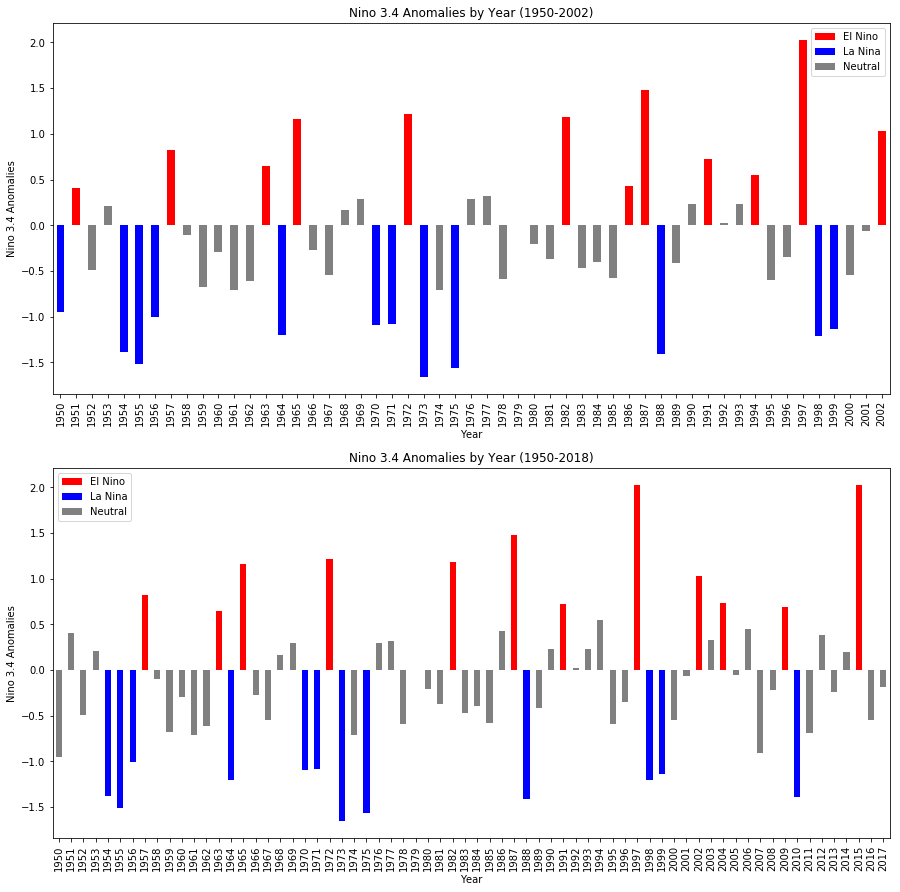

In [53]:
#Replicating Figure 1 from Camargo and Sobel (2004)

fig, axes = plt.subplots(figsize=(15,15), nrows=2)
ax0, ax1 = axes

#plot mean anomalies for each year from 1950-2002
#red bars indicate El Nino years, blue bars indicate La Nina years, and gray bars indicate neutral years
past_data.ANOM3.where(past_data.ANOM3>=0.3175).plot(kind='bar',ax=ax0,color='red')
past_data.ANOM3.where(past_data.ANOM3<=-0.7125).plot(kind='bar',ax=ax0,color='blue')
past_data.ANOM3.where((past_data.ANOM3>=-0.7125)&(past_data.ANOM3<=0.3175)).plot(kind='bar',ax=ax0,color='gray')
ax0.set_xlabel("Year")
ax0.set_ylabel("Nino 3.4 Anomalies")
ax0.set_title('Nino 3.4 Anomalies by Year (1950-2002)')
ax0.legend(['El Nino','La Nina','Neutral'])

#plot mean anomalies for each year from 1950-2002
present_data.ANOM3.where(present_data.ANOM3>=0.545).plot(kind='bar',ax=ax1,color='red')
present_data.ANOM3.where(present_data.ANOM3<=-0.9525).plot(kind='bar',ax=ax1,color='blue')
present_data.ANOM3.where((present_data.ANOM3>=-0.9525)&(present_data.ANOM3<=0.545)).plot(kind='bar',ax=ax1,color='gray')
ax1.set_title('Nino 3.4 Anomalies by Year (1950-2018)')
ax1.set_xlabel("Year")
ax1.set_ylabel("Nino 3.4 Anomalies")
ax1.legend(['El Nino','La Nina','Neutral']);

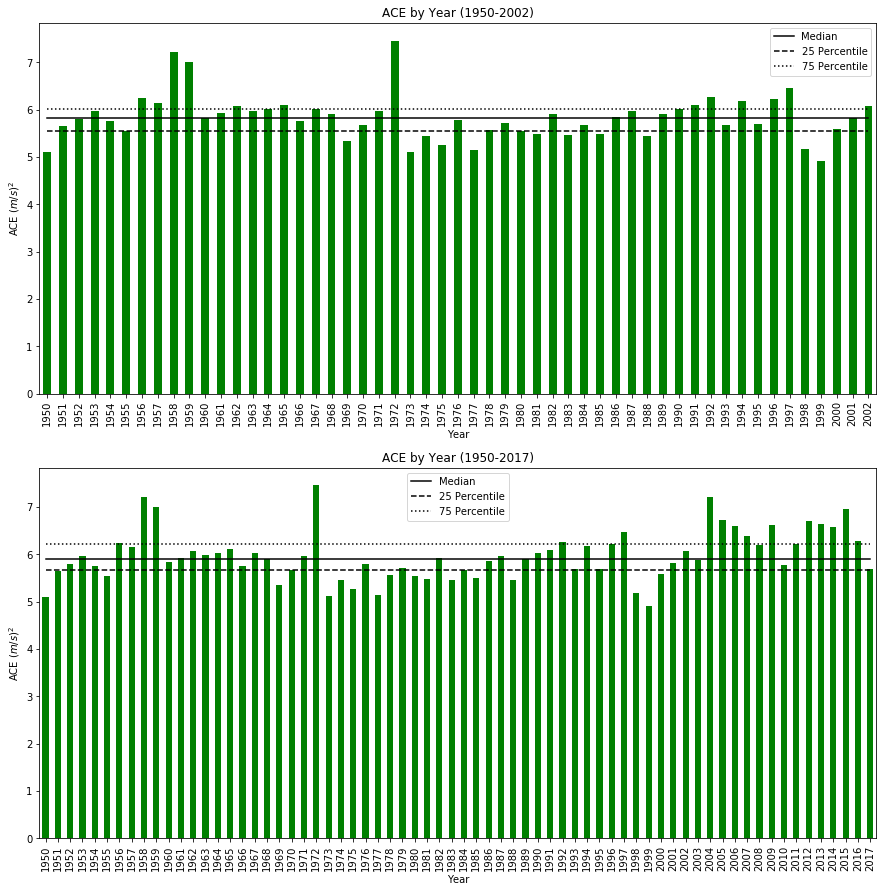

In [59]:
#Replicating Figure 1b from Camargo and Sobel (2004)

fig, axes = plt.subplots(figsize=(15,15), nrows=2)
ax0, ax1 = axes

past_data.ACE.plot(kind='bar',ax=ax0,color='green') #plot ACE for each year from 1950-2002
median=[np.median(past_data.ACE) for i in past_data.ACE] #median is 5.82
percent25=[np.percentile(past_data.ACE,25) for i in past_data.ACE]
percent75=[np.percentile(past_data.ACE,75) for i in past_data.ACE]
ax0.plot(median,color='black')
ax0.plot(percent25,color='black',linestyle='--')
ax0.plot(percent75,color='black',linestyle=':')
ax0.set_xlabel("Year")
ax0.set_ylabel("ACE $(m/s)^2$")
ax0.set_title('ACE by Year (1950-2002)')
ax0.legend(['Median','25 Percentile','75 Percentile'])


present_data.ACE.plot(kind='bar',ax=ax1,color='green') #plot ACE for each year from 1950-2002
median2=[np.median(present_data.ACE) for i in present_data.ACE] #median is 5.91
percent25_2=[np.percentile(present_data.ACE,25) for i in present_data.ACE]
percent75_2=[np.percentile(present_data.ACE,75) for i in present_data.ACE]
ax1.plot(median2,color='black')
ax1.plot(percent25_2,color='black',linestyle='--')
ax1.plot(percent75_2,color='black',linestyle=':')
ax1.set_title('ACE by Year (1950-2017)')
ax1.set_xlabel("Year")
ax1.set_ylabel("ACE $(m/s)^2$")
ax1.legend(['Median','25 Percentile','75 Percentile']);

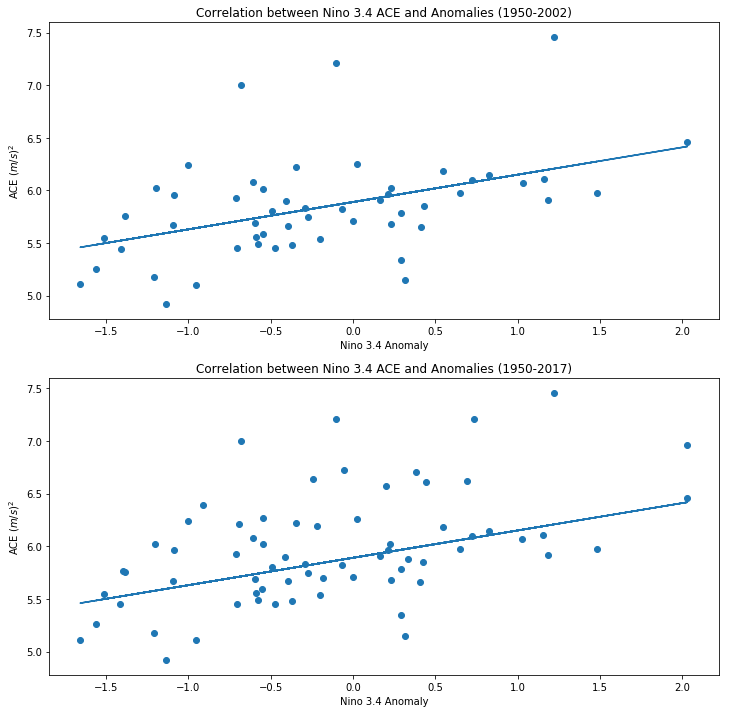

In [16]:
#Replicating Figure 2 from Camargo and Sobel (2004)

fig, axes = plt.subplots(figsize=(12,12), nrows=2)
ax0, ax1 = axes

p = np.polyfit(past_data.ANOM3,past_data.ACE, deg=1)
x = past_data.ANOM3
y = p[1] + p[0] * past_data.ANOM3
#above steps used to make regression line
ax0.scatter(x,past_data.ACE) #plot all ACE and anomaly values from 1950-2002
ax0.plot(x, y) #plot regression line
ax0.set_xlabel("Nino 3.4 Anomaly")
ax0.set_ylabel("ACE $(m/s)^2$")
ax0.set_title('Correlation between Nino 3.4 ACE and Anomalies (1950-2002)')


present_data=present_data[present_data.index !=2018] #remove 2018 since it produces NaN results
p2 = np.polyfit(present_data.ANOM3,present_data.ACE, deg=1)
x2 = present_data.ANOM3
y2 = p[1] + p[0] * present_data.ANOM3
ax1.scatter(x2,present_data.ACE) #plot all ACE and anomaly values from 1950-2017
ax1.plot(x2, y2)
ax1.set_xlabel("Nino 3.4 Anomaly")
ax1.set_ylabel("ACE $(m/s)^2$")
ax1.set_title('Correlation between Nino 3.4 ACE and Anomalies (1950-2017)');

In [77]:
from scipy import stats
stats.linregress(past_data.ANOM3,past_data.ACE)
#correlation is significant (p<0.05)

LinregressResult(slope=0.2597810111415447, intercept=5.890536063023559, rvalue=0.4553853563072438, pvalue=0.0006119300106354145, stderr=0.07111757042344789)

In [78]:
stats.linregress(present_data.ANOM3,present_data.ACE)
#correlation is significant (p<0.05)

LinregressResult(slope=0.30703377110751623, intercept=6.0145170447248, rvalue=0.4860201005230692, pvalue=2.6498548686033883e-05, stderr=0.06795874617542387)

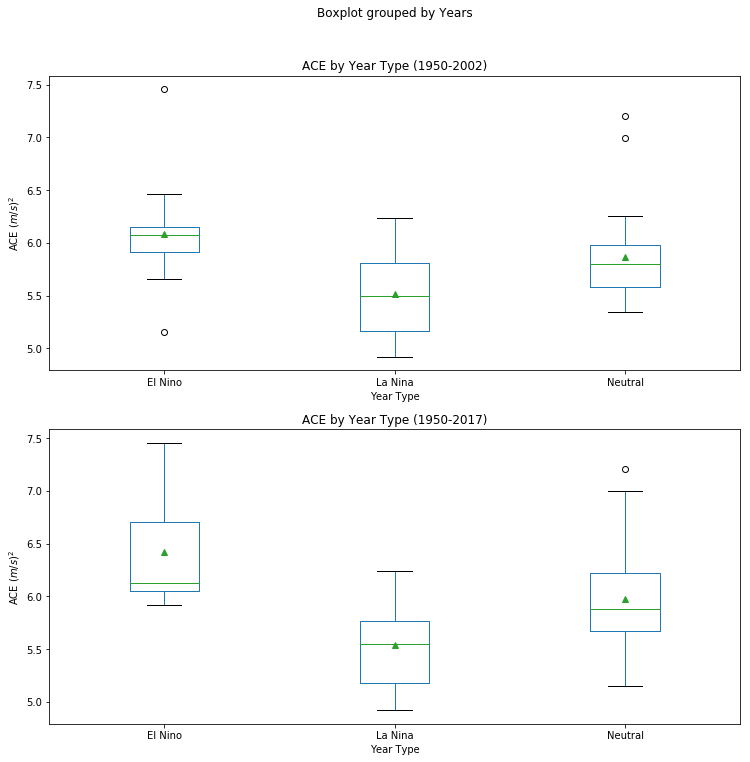

In [70]:
#Replicating Figure 3 from Camargo and Sobel (2004)

fig, axes = plt.subplots(figsize=(12,12), nrows=2)
ax0, ax1 = axes


#plot ACE for each year type from 1950-2002
past_data.boxplot(column='ACE',by='Years',grid=False,showmeans=True,ax=ax0) 
ax0.set_xlabel("Year Type")
ax0.set_ylabel("ACE $(m/s)^2$")
ax0.set_title('ACE by Year Type (1950-2002)')

#plot ACE for each year type from 1950-2002
present_data.boxplot(column='ACE',by='Years',grid=False,showmeans=True,ax=ax1) 
ax1.set_title('ACE by Year Type (1950-2017)')
ax1.set_xlabel("Year Type")
ax1.set_ylabel("ACE $(m/s)^2$");

##### Overall the various trends observed by Camargo and Sobel(2004) appear to stay consistent to the present day, as ACE values continue to remain significantly positively correlated with higher anomalies (Figure 2), indicating that storms are generally more powerful in El Nino years compared to La Nina ones and storm strength in neutral years lay somewhere in between, as observed in Figure 3. Additionally, with the inclusion of data from 2003-2018, some of these trends have become more prominent with more recent storms replacing years that were considered part of El Nino or La Nina in the study, as seen in Figure 1a in which 2010 and 2016 have replaced 1950 and 1951 as La Nina and El Nino years respectively. Similarly, the more emphasized values of these two storms have also noticeably shifted the positions of El Nino and La Nina in Figure 3, with the former placed higher than before and the latter shifted slightly lower. 

##### Unfortunately I was unable to replicate Figure 7 from the paper as I had proposed due to personal confusion regarding how storms categorized on the website matched with storms defined in the paper, as NTY and INTY specifically mentioned category strengths that I could not locate in the dataset. Additionally, no storms were identified as TC (tropical cyclone) and though some storms were categorized under TS (tropical storm), I was uncertain of the best way to differentiate them due to inability to determine unique traits that could be used to identify each storm, as many had no names and I could only guess based on their dates, so I chose to omit this figure from my project.